In [23]:
import os
import json
import pandas as pd
import numpy as np

In [24]:
def generate_labels(file_list):
    labels = {}
    for file in file_list:
        f = open(file)
        data = json.load(f)
        name = file.split(".json")[0].split("/")[-1] # take file name sans the file extension
        labels[name] = {"phase_id": data["sample"]["material"]["phase_id"]}
        # FIND TEC IN 1e-6/K UNITS
        property_name = data["sample"]["measurement"][0]["property"]["name"]
        # Check if JSON reports the linear or bulk TEC
        if property_name == "linear thermal expansion coefficient":    
            labels[name].update({"thermal_expansion": 1e6*data["sample"]["measurement"][0]["property"]["scalar"]})  
        elif property_name == "volume thermal expansion coefficient":
            # Convert volume TEC to linear TEC by dividing by 3 (valid due to small value approx)
            labels[name].update({"thermal_expansion": (1e6/3)*data["sample"]["measurement"][0]["property"]["scalar"]})
        else:
            raise Exception("Unexpected property found: ", property_name)
        
        # Save temperature conditions of 
        if "scalar" in data["sample"]["measurement"][0]["condition"][0].keys():
            labels[name].update({"temperature": data["sample"]["measurement"][0]["condition"][0]["scalar"]})
        else:
            # If a range of temperatures is given, record the midpoint 
            labels[name].update({"temperature": np.mean(data["sample"]["measurement"][0]["condition"][0]["range"])})
            # TODO: dont just use mean of data range?
        
        f.close()
        
    # Save to file
    labels_df = pd.DataFrame.from_dict(labels).T
    return labels_df

## Compile all JSON files into a single labels file

In [25]:
output_dir = "labels/"  # Output labels

## PROCESS LINEAR TEC LABELS
# File Management
input_dirs = ["oxide_volume/", "fluoride_volume/"]  # Input json files
filename = "labels_volume.csv"  # name of labels file

if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# Load all CIF files in
file_type = ".json"
files = []
for input_dir in input_dirs:
    files_found = os.listdir(input_dir)
    files += [input_dir+i for i in files_found]  # Append folder extension to file name
json_files = [file for file in files if file.endswith(file_type)]
num_files = len(json_files)

generate_labels(json_files).to_csv(output_dir+filename)

## PROCESS VOLUME TEC LABELS
# File Management
input_dirs = ["oxide_linear/", "fluoride_linear/"]  # Input json files
filename = "labels_linear.csv"  # name of labels file

# Load all CIF files in
file_type = ".json"
files = []
for input_dir in input_dirs:
    files_found = os.listdir(input_dir)
    files += [input_dir+i for i in files_found]
json_files = [file for file in files if file.endswith(file_type)]
num_files += len(json_files)

generate_labels(json_files).to_csv(output_dir+filename)

print("Processed files: ", num_files)

Processed files:  1979


## Check for series of linear TECs that are reported as a single Volume TEC

In [26]:
# Why is this step needed? Many linear TEC values are directional in the lattice leaving 3x different labels for many structures. Instead we use the volume TEC for these entries
# Load all label CSV files in
# Load and process Volume TEC Labels
vol_df = pd.read_csv("labels/labels_volume.csv", index_col= 0)
vol_df['entry'] = vol_df.index.astype(str).str.split('-').str[0]
vol_df = vol_df.sort_values(by=['phase_id', 'entry', 'temperature'], ascending=[False, False, False])
vol_df['dil_data'] = 0  
vol_df['xrd_data'] = 1 # Measured with XRD until proven otherwise

lin_df = pd.read_csv("labels/labels_linear.csv", index_col=0)
lin_df['entry'] = lin_df.index.astype(str).str.split('-').str[0]
lin_df = lin_df.sort_values(by=['phase_id', 'entry', 'temperature'], ascending=[False, False, False])
lin_df['dil_data'] = 1 # Measured with dilatometry until proven otherwise
lin_df['xrd_data'] = 0

In [27]:
len(lin_df)

1659

In [28]:
len(vol_df)

289

In [29]:
# Compare duplicate volume TECs
# Pull out duplicates
vol_duplicates = vol_df[vol_df[['phase_id', 'entry', 'temperature']].duplicated(keep=False) == True]
matches = list()
match_tecs = list()
prev_entry = vol_duplicates.iloc[0,[0, 2, 3]]

print("REMOVING THESE VOLUME TEC DISCREPENCIES")
for row in vol_duplicates.index:
    entry = vol_duplicates.loc[row, ['phase_id', 'temperature', 'entry']]
    if entry.equals(prev_entry):
        matches.append(row)
        match_tecs.append(float(vol_duplicates.loc[row, 'thermal_expansion']))
    else:
        if len(matches) >= 2 and np.abs(np.std(match_tecs)/(1e-5+np.mean(match_tecs))) > 0.1: # high variance in values
            print(matches)
            print(match_tecs)
            # Remove these weird values
            vol_df = vol_df.drop(matches)
        matches = [row]
        match_tecs = [float(vol_duplicates.loc[row, 'thermal_expansion'])]
    prev_entry = entry.copy()

REMOVING THESE VOLUME TEC DISCREPENCIES
['P1907559-14', 'P1907559-15']
[-8.0, -10.0]
['P1308593-21', 'P1308593-19']
[0.7666666666666666, 1.5666666666666664]


In [30]:
# Check if a volume TEC can be used to replace 3+ directional linear TECs
vol_labs_matched = 0
lin_labs_removed = 0
for row in vol_df.index:
    vol_entry = vol_df.loc[row, ['phase_id', 'temperature', 'entry']]
    phase = vol_df.loc[row, 'entry']
    matches = list()
    for i in lin_df.index:
        if lin_df.loc[i, ['phase_id', 'temperature', 'entry']].equals(vol_entry):
            matches.append(i)
    if len(matches) >= 3:
        print(matches)
        vol_labs_matched += 1
        lin_labs_removed += len(matches)
        lin_df = lin_df.drop(matches)

print("Volume TECs matched with Lin TECs: ", vol_labs_matched)
print("Redundant linear TECs removed: ", lin_labs_removed)

['P1127173-3', 'P1127173-4', 'P1127173-2']
['P1110928-2', 'P1110928-3', 'P1110928-1']
['P1118650-3', 'P1118650-1', 'P1118650-2']
['P1317442-4', 'P1317442-5', 'P1317442-3']
['P1317441-2', 'P1317441-3', 'P1317441-4']
['P1712101-3', 'P1712101-4', 'P1712101-2']
['P1913322-7', 'P1913322-9', 'P1913322-8']
['P1712100-2', 'P1712100-4', 'P1712100-3']
['P1911327-2', 'P1911327-3', 'P1911327-4']
['P1811326-6', 'P1811326-4', 'P1811326-5']
['P1822379-1', 'P1822379-3', 'P1822379-2']
['P1128949-9', 'P1128949-8', 'P1128949-7']
['P1108804-6', 'P1108804-7', 'P1108804-5']
['P1108804-3', 'P1108804-2', 'P1108804-4']
['P1108806-9', 'P1108806-8', 'P1108806-7']
['P1108806-5', 'P1108806-6', 'P1108806-4']
['P1123568-4', 'P1123568-3', 'P1123568-2']
['P1520222-4', 'P1520222-3', 'P1520222-5']
['P1520221-2', 'P1520221-4', 'P1520221-3']
['P1110927-4', 'P1110927-3', 'P1110927-2']
['P1712806-10', 'P1712806-8', 'P1712806-9', 'P1712806-6', 'P1712806-5', 'P1712806-7']
['P1810746-4', 'P1810746-2', 'P1810746-3']
['P1810745-

## Now sort through Duplicate Linear TECs not found listed as a Volume TEC

In [31]:
# Now combine duplicate linear TECs with no corresponding volume label
num_replacements = 0  # Count number of times duplicates are replaced to report
num_lin_removed = 0
matches = list()
match_tecs = list()
lin_df = lin_df.sort_index(axis=0)
prev_entry = lin_df.iloc[0,[0, 2, 3]]
for row in lin_df.index:
    entry = lin_df.loc[row, ['phase_id', 'temperature', 'entry']]
    if entry.equals(prev_entry):
        matches.append(row)
        match_tecs.append(float(lin_df.loc[row, 'thermal_expansion']))
    else:
        if len(matches) >= 2:
            print(matches)
            # Toss all but the first entry which will be modified
            lin_df = lin_df.drop(matches[1:])  
            num_lin_removed += len(matches[1:])
            # Make this entry the average of all entries, assuming these represent thermal expansion in different directions
            if len(matches) == 2: 
                # TODO: make this more rigorous
                # Here, typically [1,0,0] and [0,0,1] planes are listed with it implied the [0,1,0] plane is same as first
                lin_df.at[matches[0], 'thermal_expansion'] = (2/3)*match_tecs[0] + (1/3)*match_tecs[1]
            elif len(matches) == 3:
                # May list 3 primary planes as well as other planes
                lin_df.at[matches[0], 'thermal_expansion'] = np.mean(match_tecs)  # Additional value may be for other planes
            else:
                print("More than 3 matches found...")
                print(match_tecs)
                lin_df.at[matches[0], 'thermal_expansion'] = np.mean(match_tecs)
            num_replacements += 1
            
            # TODO: Assume that this is XRD Data probably
            lin_df.loc[matches[0], 'dil_data'] = 0
            lin_df.loc[matches[0], 'xrd_data'] = 1
            
        matches = [row]
        match_tecs = [float(lin_df.loc[row, 'thermal_expansion'])]
            
    prev_entry = entry.copy()  
          
print("Duplicates calculated by combining linear TEC: ", num_replacements)
print("Linear labels removed: ", num_lin_removed)

# Now combine and see how many duplicates are left
labels_df = pd.concat( (lin_df, vol_df))

# Filter by TEC value!
labels_df = labels_df[(labels_df.thermal_expansion > 0) & (labels_df.thermal_expansion < 100)]
labels_df = labels_df[(labels_df.temperature >= 150) & (labels_df.temperature < 2000)]

labels_df = labels_df.sort_index()
print("Remaining Labels: ", len(labels_df))
labels_df.to_csv("labels/labels.csv")

P1004814-3
P1100654-21
P1100654-22
P1101042-7
['P1100654-21', 'P1100654-22']
P1101182-3
P1101182-4
P1101183-10
['P1101182-3', 'P1101182-4']
P1101183-9
P1101900-2
['P1101183-10', 'P1101183-9']
P1101900-3
P1101900-4
P1101901-2
['P1101900-2', 'P1101900-3', 'P1101900-4']
P1101901-3
P1101901-4
P1102307-3
['P1101901-2', 'P1101901-3', 'P1101901-4']
P1102312-1
P1102312-2
P1102312-3
P1102443-5
['P1102312-1', 'P1102312-2', 'P1102312-3']
P1102443-6
P1102444-5
['P1102443-5', 'P1102443-6']
P1102444-6
P1102444-7
P1102444-8
P1102563-2
['P1102444-7', 'P1102444-8']
P1102563-3
P1103107-3
['P1102563-2', 'P1102563-3']
P1103108-2
P1103989-2
P1105079-2
P1105079-3
P1105608-2
['P1105079-2', 'P1105079-3']
P1105711-5
P1105712-5
P1105713-5
P1105714-4
P1105715-4
P1105716-5
P1105717-8
P1105718-8
P1106073-8
P1106073-9
P1106495-1
['P1106073-8', 'P1106073-9']
P1106495-2
P1106495-3
['P1106495-1', 'P1106495-2']
P1106495-4
P1106495-5
P1106597-5
['P1106495-3', 'P1106495-4', 'P1106495-5']
P1106597-6
P1106598-4
['P1106597-

P1301927-3
P1301927-4
P1301927-5
P1301927-6
P1301927-7
P1301928-10
P1301928-11
P1301928-12
P1301928-7
P1301928-8
P1301928-9
P1301929-3
P1301929-4
P1301929-5
P1301929-6
P1301929-7
P1301929-8
P1301930-2
P1301930-3
P1301930-4
P1301930-5
P1301930-6
P1301930-7
P1301977-10
P1301977-11
P1301977-12
P1301977-13
P1301977-2
P1301977-3
P1301977-4
P1301977-5
P1301977-6
P1301977-7
P1301977-8
P1301977-9
P1302207-16
P1302207-17
P1302212-2
['P1302207-16', 'P1302207-17']
P1302212-3
P1302214-3
['P1302212-2', 'P1302212-3']
P1302214-4
P1303057-4
['P1302214-3', 'P1302214-4']
P1303853-7
P1303965-8
P1303965-9
P1304939-5
P1304939-6
P1305044-5
P1305044-6
P1305044-7
P1305044-8
P1305045-4
P1305045-5
P1305045-6
P1305609-5
P1305609-6
P1305852-2
['P1305609-5', 'P1305609-6']
P1305852-3
P1305860-2
P1305860-3
P1305861-1
P1305861-2
P1305949-5
P1305949-6
P1305949-7
P1305949-8
P1306249-7
P1306249-8
P1306340-2
P1306340-3
P1306551-3
['P1306340-2', 'P1306340-3']
P1306551-4
P1306551-5
P1306778-4
['P1306551-3', 'P1306551-4', '

['P1900103-1', 'P1900103-2']
P1900202-3
P1901100-11
['P1900202-2', 'P1900202-3']
P1901100-12
P1901100-13
P1901100-14
['P1901100-11', 'P1901100-12', 'P1901100-13']
P1901100-15
P1901100-16
P1901345-10
P1901345-11
P1901345-12
P1901345-13
P1901345-15
P1901345-16
P1901345-17
P1901345-7
['P1901345-15', 'P1901345-16', 'P1901345-17']
P1901345-8
P1901346-6
P1901346-7
P1901346-8
P1902829-2
['P1901346-6', 'P1901346-7', 'P1901346-8']
P1902829-3
P1902829-4
P1902830-3
P1902830-4
P1902831-2
P1902831-3
P1902962-3
P1902962-4
P1902962-5
P1902962-6
P1902962-7
P1902962-8
P1902963-2
['P1902962-6', 'P1902962-7', 'P1902962-8']
P1902963-3
P1902963-4
P1902963-5
P1902963-6
P1902963-7
['P1902963-5', 'P1902963-6']
P1902964-2
P1902964-3
P1902964-4
P1902964-5
P1902964-6
P1902964-7
P1903141-3
P1903887-7
P1903897-3
P1903897-4
P1903897-5
P1903897-6
P1903897-7
P1903897-8
P1903898-2
['P1903897-3', 'P1903897-4', 'P1903897-5', 'P1903897-6', 'P1903897-7', 'P1903897-8']
More than 3 matches found...
[2.0, 2.0, 3.0, 8.0, 8.0,

In [33]:
# TODO: find average measurement variance
labels_df[labels_df.duplicated(subset=['phase_id', 'temperature', 'entry'], keep=False)]  

,phase_id,thermal_expansion,temperature,entry,dil_data,xrd_data
P1100654-21,31133.0,3.566667,298.0,P1100654,0,1
P1100654-23,31133.0,5.333333,298.0,P1100654,0,1
P1106495-1,27058.0,22.466667,948.0,P1106495,0,1
P1106495-6,27058.0,22.966667,948.0,P1106495,0,1
P1106993-4,78504.0,9.200000,298.0,P1106993,0,1
...,...,...,...,...,...,...
P800730-6,6133.0,2.933333,298.0,P800730,0,1
P800732-1,13174.0,10.400000,298.0,P800732,1,0
P800732-2,13174.0,10.400000,298.0,P800732,0,1
P922338-19,13150.0,3.630000,298.0,P922338,1,0


## Data vs Temperature Distribution 

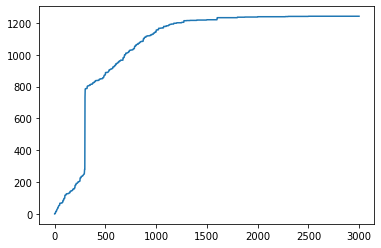

In [13]:
num = []
for i in range(3000):
    num.append(len(labels_df[labels_df.temperature <= i]))
import matplotlib.pyplot as plt
plt.plot(np.arange(3000), num)
plt.show()